# Assignment 2: Algorithmic Affordances and Interfaces

In [2]:
import pandas as pd
# load the dataset small
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
links_df = pd.read_csv('links.csv')
tags_df = pd.read_csv('tags.csv', low_memory=False)

### Getting the data ready

In [3]:
print(movies_df.shape)
movies_df.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(links_df.shape)
links_df.head()

(9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
print(ratings_df.shape)
ratings_df.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
print(tags_df.shape)
tags_df.head()

(3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [23]:
#merging all data into one big old dataframe 
all_df = movies_df.merge(ratings_df, left_on='movieId', right_on='movieId')
all_df = all_df.merge(tags_df, left_on='movieId', right_on='movieId')
all_df = all_df.merge(links_df, left_on='movieId', right_on='movieId')

In [24]:
# shape of the dataset with all data
print(all_df.shape)

# check data
all_df.head()

(233213, 11)


,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,336,pixar,1139045764,114709,862.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,474,pixar,1137206825,114709,862.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,567,fun,1525286013,114709,862.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,336,pixar,1139045764,114709,862.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,474,pixar,1137206825,114709,862.0


### Checking for Missing Values

In [25]:
# check for missing values in the data
all_df.isnull().sum()

movieId        0
title          0
genres         0
userId_x       0
rating         0
timestamp_x    0
userId_y       0
tag            0
timestamp_y    0
imdbId         0
tmdbId         0
dtype: int64

# Recommendation based on movies frequently watched together

In [69]:
from itertools import permutations

# create a function that makes combinations of the movies that a user (x) reviewed
def create_combinations(x):
    combinations = pd.DataFrame(list(permutations(x.values, 2)), columns=['movie_a', 'movie_b'])
    return combinations

In [70]:
# how many rating by user
ratings_user = all_df.groupby(['userId_x']).size().reset_index(name='counts')
ratings_user = ratings_user.set_index('userId_x')
ratings_user

,counts
userId_x,
1,593
2,143
3,27
4,580
5,278
...,...
606,1407
607,450
608,1285


In [71]:
# if I do the same thing with userId_y insead
avg_user_y = all_df.groupby(['userId_y']).size().reset_index(name='counts')
avg_user_y = avg_user_y.set_index('userId_y')
avg_user_y.head(20)

,counts
userId_y,
2,279
7,107
18,555
21,94
49,219
62,14139
63,502
76,502
103,1423


In [72]:
# more than 2 movies rated
ratings_user = ratings_user[ratings_user['counts'] > 2]
users_index = ratings_user.index
users_index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
           dtype='int64', name='userId_x', length=610)

In [73]:
# now using the function we created in the beginning
# use the create_combinations function

movie_combinations = all_df.groupby('userId_x')['title'].apply(create_combinations)
movie_combinations.head()

movie_a                      movie_b
userId_x                                                 
1        0  Toy Story (1995)             Toy Story (1995)
         1  Toy Story (1995)             Toy Story (1995)
         2  Toy Story (1995)      Grumpier Old Men (1995)
         3  Toy Story (1995)      Grumpier Old Men (1995)
         4  Toy Story (1995)  Seven (a.k.a. Se7en) (1995)

In [74]:
# calculate the occurences of the movie a and movie b
movie_combinations = movie_combinations.reset_index(drop=True)
combi_count = movie_combinations.groupby(['movie_a', 'movie_b']).size()
combi_count = combi_count.to_frame(name='occurance').reset_index()
combi_count.sort_values('occurance', ascending=False).head(5)


,movie_a,movie_b,occurance
1357562,Pulp Fiction (1994),Pulp Fiction (1994),10002060
553767,Fight Club (1999),Pulp Fiction (1994),1544292
1356930,Pulp Fiction (1994),Fight Club (1999),1544292
1357781,Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),724724
1643533,Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),724724


In [75]:
# search for a great movie to see what other not as great movies are suggested 
combi_count[combi_count['movie_a'] == 'Fight Club (1999)'].sort_values('occurance', ascending=False).head(10)

,movie_a,movie_b,occurance
553767,Fight Club (1999),Pulp Fiction (1994),1544292
553144,Fight Club (1999),Fight Club (1999),623916
553986,Fight Club (1999),Star Wars: Episode IV - A New Hope (1977),188136
553107,Fight Club (1999),Eternal Sunshine of the Spotless Mind (2004),187272
553502,Fight Club (1999),Léon: The Professional (a.k.a. The Professiona...,164430
553360,Fight Club (1999),Inception (2010),153036
552853,Fight Club (1999),"Big Lebowski, The (1998)",145152
552721,Fight Club (1999),2001: A Space Odyssey (1968),141696
553070,Fight Club (1999),Donnie Darko (2001),137808
553550,Fight Club (1999),Memento (2000),86346


## Implementation on Interface
Right now one could use these recommendations to find movies that have frequently been seen together. 
Additionally I want it to be possible to search for a movie and get other suggestions of movies that were oftentimes seen by the same users. 
This is especially useful when the movie the user is looking for is not available - at least there is alternative movies that the user can watch. 


In [226]:
# searching for a movie that might fit
search = input('\n Let us know what movie you enjoyed so that we can find one that you might like')

# the common movie pairs as found through occurance
common_movies = combi_count[combi_count['movie_a'] == search].sort_values("occurance", ascending=False)
# reset the index 
common_movies = common_movies.reset_index(drop=True)

#example for text on interface as a result to the search
print("\nUsers that watched {} also watched:\n".format(search))
common_movies.sort_values("occurance", ascending=False).movie_b.head(10)


 Let us know what movie you enjoyed so that we can find one that you might like Fight Club (1999)



Users that watched Fight Club (1999) also watched:



0                                  Pulp Fiction (1994)
1                                    Fight Club (1999)
2            Star Wars: Episode IV - A New Hope (1977)
3         Eternal Sunshine of the Spotless Mind (2004)
4    Léon: The Professional (a.k.a. The Professiona...
5                                     Inception (2010)
6                             Big Lebowski, The (1998)
7                         2001: A Space Odyssey (1968)
8                                  Donnie Darko (2001)
9                                       Memento (2000)
Name: movie_b, dtype: object

# Recommendations based on jaccard similarity in genres

In [26]:
# check data again 
all_df.head()

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,336,pixar,1139045764,114709,862.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,474,pixar,1137206825,114709,862.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,567,fun,1525286013,114709,862.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,336,pixar,1139045764,114709,862.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,474,pixar,1137206825,114709,862.0


In [27]:
# first get rid of the duplicates of movies
#single_df = all_df.drop_duplicates(subset=['title'])
single_df = all_df.copy().drop_duplicates(subset=['title'])

In [28]:
single_df

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,336,pixar,1139045764,114709,862.0
645,2,Jumanji (1995),Adventure|Children|Fantasy,6,4.0,845553522,62,fantasy,1528843929,113497,8844.0
1085,3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247,289,moldy,1143424860,113228,15602.0
1189,5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938,474,pregnancy,1137373903,113041,11862.0
1287,7,Sabrina (1995),Comedy|Romance,6,4.0,845554264,474,remake,1137375642,114319,11860.0
...,...,...,...,...,...,...,...,...,...,...,...
233148,183611,Game Night (2018),Action|Comedy|Crime|Horror,62,4.0,1526244681,62,Comedy,1526244689,2704998,445571.0
233151,184471,Tomb Raider (2018),Action|Adventure|Fantasy,62,3.5,1528024895,62,adventure,1528024900,1365519,338970.0
233163,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,25,5.0,1535470534,62,Josh Brolin,1527274096,5463162,383498.0
233199,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,62,4.0,1528934550,62,Emilia Clarke,1528934560,3778644,348350.0


In [29]:
single_df['genres'] = single_df.genres.apply(lambda x: x.replace('|', ', '))
single_df

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",1,4.0,964982703,336,pixar,1139045764,114709,862.0
645,2,Jumanji (1995),"Adventure, Children, Fantasy",6,4.0,845553522,62,fantasy,1528843929,113497,8844.0
1085,3,Grumpier Old Men (1995),"Comedy, Romance",1,4.0,964981247,289,moldy,1143424860,113228,15602.0
1189,5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938,474,pregnancy,1137373903,113041,11862.0
1287,7,Sabrina (1995),"Comedy, Romance",6,4.0,845554264,474,remake,1137375642,114319,11860.0
...,...,...,...,...,...,...,...,...,...,...,...
233148,183611,Game Night (2018),"Action, Comedy, Crime, Horror",62,4.0,1526244681,62,Comedy,1526244689,2704998,445571.0
233151,184471,Tomb Raider (2018),"Action, Adventure, Fantasy",62,3.5,1528024895,62,adventure,1528024900,1365519,338970.0
233163,187593,Deadpool 2 (2018),"Action, Comedy, Sci-Fi",25,5.0,1535470534,62,Josh Brolin,1527274096,5463162,383498.0
233199,187595,Solo: A Star Wars Story (2018),"Action, Adventure, Children, Sci-Fi",62,4.0,1528934550,62,Emilia Clarke,1528934560,3778644,348350.0


In [30]:
single_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1554 entries, 0 to 233209
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      1554 non-null   int64  
 1   title        1554 non-null   object 
 2   genres       1554 non-null   object 
 3   userId_x     1554 non-null   int64  
 4   rating       1554 non-null   float64
 5   timestamp_x  1554 non-null   int64  
 6   userId_y     1554 non-null   int64  
 7   tag          1554 non-null   object 
 8   timestamp_y  1554 non-null   int64  
 9   imdbId       1554 non-null   int64  
 10  tmdbId       1554 non-null   float64
dtypes: float64(2), int64(6), object(3)
memory usage: 145.7+ KB


In [31]:
# first tried with genres and tag together
# single_df['new_category'] = single_df['genres'] + ', ' + single_df['tag']
# resulted in very many unique vategories which doesn't help much

single_df['new_category'] = single_df['genres']
single_df

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId,new_category
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",1,4.0,964982703,336,pixar,1139045764,114709,862.0,"Adventure, Animation, Children, Comedy, Fantasy"
645,2,Jumanji (1995),"Adventure, Children, Fantasy",6,4.0,845553522,62,fantasy,1528843929,113497,8844.0,"Adventure, Children, Fantasy"
1085,3,Grumpier Old Men (1995),"Comedy, Romance",1,4.0,964981247,289,moldy,1143424860,113228,15602.0,"Comedy, Romance"
1189,5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938,474,pregnancy,1137373903,113041,11862.0,Comedy
1287,7,Sabrina (1995),"Comedy, Romance",6,4.0,845554264,474,remake,1137375642,114319,11860.0,"Comedy, Romance"
...,...,...,...,...,...,...,...,...,...,...,...,...
233148,183611,Game Night (2018),"Action, Comedy, Crime, Horror",62,4.0,1526244681,62,Comedy,1526244689,2704998,445571.0,"Action, Comedy, Crime, Horror"
233151,184471,Tomb Raider (2018),"Action, Adventure, Fantasy",62,3.5,1528024895,62,adventure,1528024900,1365519,338970.0,"Action, Adventure, Fantasy"
233163,187593,Deadpool 2 (2018),"Action, Comedy, Sci-Fi",25,5.0,1535470534,62,Josh Brolin,1527274096,5463162,383498.0,"Action, Comedy, Sci-Fi"
233199,187595,Solo: A Star Wars Story (2018),"Action, Adventure, Children, Sci-Fi",62,4.0,1528934550,62,Emilia Clarke,1528934560,3778644,348350.0,"Action, Adventure, Children, Sci-Fi"


In [33]:
# cast the new category to a list 
single_df['new_category']=single_df.new_category.str.split(', ').tolist()
single_df

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId,new_category
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",1,4.0,964982703,336,pixar,1139045764,114709,862.0,"[Adventure, Animation, Children, Comedy, Fantasy]"
645,2,Jumanji (1995),"Adventure, Children, Fantasy",6,4.0,845553522,62,fantasy,1528843929,113497,8844.0,"[Adventure, Children, Fantasy]"
1085,3,Grumpier Old Men (1995),"Comedy, Romance",1,4.0,964981247,289,moldy,1143424860,113228,15602.0,"[Comedy, Romance]"
1189,5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938,474,pregnancy,1137373903,113041,11862.0,[Comedy]
1287,7,Sabrina (1995),"Comedy, Romance",6,4.0,845554264,474,remake,1137375642,114319,11860.0,"[Comedy, Romance]"
...,...,...,...,...,...,...,...,...,...,...,...,...
233148,183611,Game Night (2018),"Action, Comedy, Crime, Horror",62,4.0,1526244681,62,Comedy,1526244689,2704998,445571.0,"[Action, Comedy, Crime, Horror]"
233151,184471,Tomb Raider (2018),"Action, Adventure, Fantasy",62,3.5,1528024895,62,adventure,1528024900,1365519,338970.0,"[Action, Adventure, Fantasy]"
233163,187593,Deadpool 2 (2018),"Action, Comedy, Sci-Fi",25,5.0,1535470534,62,Josh Brolin,1527274096,5463162,383498.0,"[Action, Comedy, Sci-Fi]"
233199,187595,Solo: A Star Wars Story (2018),"Action, Adventure, Children, Sci-Fi",62,4.0,1528934550,62,Emilia Clarke,1528934560,3778644,348350.0,"[Action, Adventure, Children, Sci-Fi]"


In [35]:
# explode into rows
single_df = single_df.explode('new_category')
single_df.tail()

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId,new_category
233199,187595,Solo: A Star Wars Story (2018),"Action, Adventure, Children, Sci-Fi",62,4.0,1528934550,62,Emilia Clarke,1528934560,3778644,348350.0,Sci-Fi
233209,193565,Gintama: The Movie (2010),"Action, Animation, Comedy, Sci-Fi",184,3.5,1537098554,184,anime,1537098582,1636780,71172.0,Action
233209,193565,Gintama: The Movie (2010),"Action, Animation, Comedy, Sci-Fi",184,3.5,1537098554,184,anime,1537098582,1636780,71172.0,Animation
233209,193565,Gintama: The Movie (2010),"Action, Animation, Comedy, Sci-Fi",184,3.5,1537098554,184,anime,1537098582,1636780,71172.0,Comedy
233209,193565,Gintama: The Movie (2010),"Action, Animation, Comedy, Sci-Fi",184,3.5,1537098554,184,anime,1537098582,1636780,71172.0,Sci-Fi


In [36]:
# Crosstab with new category and title of the movies
movies_new_category = pd.crosstab(single_df['title'], single_df['new_category'])
movies_new_category

new_category,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...And Justice for All (1979),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
10 Cloverfield Lane (2016),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10 Things I Hate About You (1999),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
101 Dalmatians (1996),0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Dark Thirty (2012),0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
Zombieland (2009),0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Zoolander (2001),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# check if this makes sense with category
single_df['new_category'].unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Crime', 'Thriller', 'Horror', 'Mystery',
       'Sci-Fi', 'War', 'Musical', 'Action', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [38]:
# import metrics sklearn for similarity and distance
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

# calculate the jaccard distances
jaccard_distances = pdist(movies_new_category.values, metric='jaccard')
square_jaccard_distances = squareform(jaccard_distances)

# check the array
square_jaccard_distances

array([[0.        , 0.75      , 1.        , ..., 0.66666667, 0.8       ,
        1.        ],
       [0.75      , 0.        , 0.5       , ..., 1.        , 0.75      ,
        0.75      ],
       [1.        , 0.5       , 0.        , ..., 1.        , 1.        ,
        0.66666667],
       ...,
       [0.66666667, 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.8       , 0.75      , 1.        , ..., 1.        , 0.        ,
        0.8       ],
       [1.        , 0.75      , 0.66666667, ..., 1.        , 0.8       ,
        0.        ]])

In [55]:
# similarity is 1 minus the distance
jaccard_similarity_array = 1 - square_jaccard_distances
jaccard_similarity_array

array([[1.        , 0.25      , 0.        , ..., 0.33333333, 0.2       ,
        0.        ],
       [0.25      , 1.        , 0.5       , ..., 0.        , 0.25      ,
        0.25      ],
       [0.        , 0.5       , 1.        , ..., 0.        , 0.        ,
        0.33333333],
       ...,
       [0.33333333, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.2       , 0.25      , 0.        , ..., 0.        , 1.        ,
        0.2       ],
       [0.        , 0.25      , 0.33333333, ..., 0.        , 0.2       ,
        1.        ]])

In [56]:
# to dataframe
distance_df = pd.DataFrame(jaccard_similarity_array, index=movies_new_category.index, columns=movies_new_category.index)
distance_df

title,(500) Days of Summer (2009),...And Justice for All (1979),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),"11'09""01 - September 11 (2002)",12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),...,Young Frankenstein (1974),Z (1969),Zack and Miri Make a Porno (2008),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zulu (1964),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),1.000000,0.250000,0.000000,0.666667,0.200000,0.0,0.333333,0.333333,0.200000,0.500000,...,0.250000,0.200000,1.000000,0.666667,0.333333,0.200000,0.200000,0.333333,0.20,0.000000
...And Justice for All (1979),0.250000,1.000000,0.500000,0.000000,0.000000,0.0,0.500000,0.500000,0.666667,0.000000,...,0.000000,0.666667,0.250000,0.333333,0.000000,0.666667,0.000000,0.000000,0.25,0.250000
10 Cloverfield Lane (2016),0.000000,0.500000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,...,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.00,0.333333
10 Things I Hate About You (1999),0.666667,0.000000,0.000000,1.000000,0.250000,0.0,0.000000,0.000000,0.000000,0.666667,...,0.333333,0.000000,0.666667,0.333333,0.500000,0.000000,0.250000,0.500000,0.00,0.000000
101 Dalmatians (1996),0.200000,0.000000,0.000000,0.250000,1.000000,0.5,0.000000,0.000000,0.200000,0.200000,...,0.250000,0.000000,0.200000,0.000000,0.333333,0.000000,0.200000,0.333333,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Dark Thirty (2012),0.200000,0.666667,0.333333,0.000000,0.000000,0.0,0.333333,0.333333,0.500000,0.000000,...,0.000000,0.500000,0.200000,0.250000,0.000000,1.000000,0.200000,0.000000,0.50,0.500000
Zombieland (2009),0.200000,0.000000,0.000000,0.250000,0.200000,0.0,0.000000,0.000000,0.000000,0.200000,...,0.250000,0.000000,0.200000,0.000000,0.333333,0.200000,1.000000,0.333333,0.20,0.200000
Zoolander (2001),0.333333,0.000000,0.000000,0.500000,0.333333,0.0,0.000000,0.000000,0.000000,0.333333,...,0.500000,0.000000,0.333333,0.000000,1.000000,0.000000,0.333333,1.000000,0.00,0.000000


In [57]:
# check if it's working with random movie and 10 suggestions by similarity
distance_df['Fight Club (1999)'].sort_values(ascending=False).head(10)

title
Fight Club (1999)                                                 1.0
Elite Squad (Tropa de Elite) (2007)                               1.0
History of Violence, A (2005)                                     1.0
Munich (2005)                                                     1.0
Taken 2 (2012)                                                    1.0
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)    1.0
Hard-Boiled (Lat sau san taam) (1992)                             1.0
Clear and Present Danger (1994)                                   1.0
Face/Off (1997)                                                   1.0
Lord of War (2005)                                                0.8
Name: Fight Club (1999), dtype: float64

## Implementation on Interface
In order to be transparent with the user it would make sense to explain why these movies are recommended. 
Here it is based on similar genres.

In [123]:
# what movie do we want (what genres in this movie)
search_movie = input('\nWhat movie are you looking for?')

# genres of that movie are
print('\nThe genres identified were: \n{}'.format(single_df["genres"].iloc[indices[search_movie]]))

# movies using the similar genres are
print('\nwhich have also been used in these movies: \n')
distance_df[search_movie].sort_values(ascending=False).head(10)


What movie are you looking for? Fight Club (1999)



The genres identified were: 
Comedy, Drama, Romance

which have also been used in these movies: 



title
Fight Club (1999)                                                 1.0
Elite Squad (Tropa de Elite) (2007)                               1.0
History of Violence, A (2005)                                     1.0
Munich (2005)                                                     1.0
Taken 2 (2012)                                                    1.0
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)    1.0
Hard-Boiled (Lat sau san taam) (1992)                             1.0
Clear and Present Danger (1994)                                   1.0
Face/Off (1997)                                                   1.0
Lord of War (2005)                                                0.8
Name: Fight Club (1999), dtype: float64

# Recommendations based on cosine similarity in tags
Recommendations based on the tags used

In [59]:
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [64]:
# check out number of unique tags
single_df.tag.nunique()

# 739 unique tags is quite a lot which might result into poor recommendations
# we'll see

739

In [65]:
# don't need all the extra columns
# smaller df with index, titla, tag, genres and count of movies
small_df = all_df.groupby(['title', 'tag', 'genres']).size().reset_index(name='counts')
small_df = small_df.reset_index().drop_duplicates()
print(small_df.shape)
small_df

(3558, 5)


,index,title,tag,genres,counts
0,0,(500) Days of Summer (2009),Funny,Comedy|Drama|Romance,42
1,1,(500) Days of Summer (2009),Zooey Deschanel,Comedy|Drama|Romance,42
2,2,(500) Days of Summer (2009),artistic,Comedy|Drama|Romance,42
3,3,(500) Days of Summer (2009),humorous,Comedy|Drama|Romance,42
4,4,(500) Days of Summer (2009),inspiring,Comedy|Drama|Romance,42
...,...,...,...,...,...
3553,3553,Zoolander (2001),comedy,Comedy,54
3554,3554,Zoolander (2001),goofy,Comedy,54
3555,3555,Zoolander (2001),mindless one liners,Comedy,54
3556,3556,Zulu (1964),Africa,Action|Drama|War,4


In [66]:
# check the tags of a movie
small_df[small_df['title']=="(500) Days of Summer (2009)"].groupby('tag')['title'].count()
# seems to make sense with table above

tag
Funny              1
Zooey Deschanel    1
artistic           1
humorous           1
inspiring          1
intelligent        1
quirky             1
romance            1
Name: title, dtype: int64

In [67]:
#need to group tags in one row
small_df_tag = small_df.copy()
# concatenate the string 
small_df_tag['tag'] = small_df_tag.groupby(['title'])['tag'].transform(lambda x : ' '.join(x)) 

small_df_tag

,index,title,tag,genres,counts
0,0,(500) Days of Summer (2009),Funny Zooey Deschanel artistic humorous inspir...,Comedy|Drama|Romance,42
1,1,(500) Days of Summer (2009),Funny Zooey Deschanel artistic humorous inspir...,Comedy|Drama|Romance,42
2,2,(500) Days of Summer (2009),Funny Zooey Deschanel artistic humorous inspir...,Comedy|Drama|Romance,42
3,3,(500) Days of Summer (2009),Funny Zooey Deschanel artistic humorous inspir...,Comedy|Drama|Romance,42
4,4,(500) Days of Summer (2009),Funny Zooey Deschanel artistic humorous inspir...,Comedy|Drama|Romance,42
...,...,...,...,...,...
3553,3553,Zoolander (2001),David Bowie Will Ferrell ben stiller comedy go...,Comedy,54
3554,3554,Zoolander (2001),David Bowie Will Ferrell ben stiller comedy go...,Comedy,54
3555,3555,Zoolander (2001),David Bowie Will Ferrell ben stiller comedy go...,Comedy,54
3556,3556,Zulu (1964),Africa,Action|Drama|War,4


In [68]:
# now we can drop the duplicates 
small_df_tag = small_df_tag.drop_duplicates(subset=['title'])  

# and reset the index
small_df_tag.reset_index(inplace=True)

# show the dataframe 
small_df_tag

,level_0,index,title,tag,genres,counts
0,0,0,(500) Days of Summer (2009),Funny Zooey Deschanel artistic humorous inspir...,Comedy|Drama|Romance,42
1,8,8,...And Justice for All (1979),lawyers,Drama|Thriller,3
2,9,9,10 Cloverfield Lane (2016),creepy suspense,Thriller,14
3,11,11,10 Things I Hate About You (1999),Shakespeare sort of,Comedy|Romance,54
4,12,12,101 Dalmatians (1996),dogs remake,Adventure|Children|Comedy,47
...,...,...,...,...,...,...
1549,3539,3539,Zero Dark Thirty (2012),Afghanistan American propaganda assassination ...,Action|Drama|Thriller,14
1550,3544,3544,Zombieland (2009),Bill Murray Emma Stone Jesse Eisenberg Woody H...,Action|Comedy|Horror,53
1551,3550,3550,Zoolander (2001),David Bowie Will Ferrell ben stiller comedy go...,Comedy,54
1552,3556,3556,Zulu (1964),Africa,Action|Drama|War,4


In [69]:
# convert into matric of tf-idf features with stopwords
tfidf = TfidfVectorizer(stop_words='english')
# fill missing values
small_df_tag['tag'] = small_df_tag['tag'].fillna('')
#transform into matrix
tag_matrix = tfidf.fit_transform(small_df_tag['tag'])
#check shape
tag_matrix.shape

<ipython-input-69-a5503aa52367>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df_tag['tag'] = small_df_tag['tag'].fillna('')


(1554, 1671)

In [74]:
# cosine similarity with matrix
cosine_sim = linear_kernel(tag_matrix, tag_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [75]:
# index by title and drop duplicates
indices = pd.Series(small_df_tag.index, index=small_df_tag['title']).drop_duplicates()
indices

title
(500) Days of Summer (2009)             0
...And Justice for All (1979)           1
10 Cloverfield Lane (2016)              2
10 Things I Hate About You (1999)       3
101 Dalmatians (1996)                   4
                                     ... 
Zero Dark Thirty (2012)              1549
Zombieland (2009)                    1550
Zoolander (2001)                     1551
Zulu (1964)                          1552
eXistenZ (1999)                      1553
Length: 1554, dtype: int64

In [76]:
def recommendations(title, cosine_sim=cosine_sim):
    
    # find the index for the movie
    idx = indices[title]

    # similarity for movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort movies on highest to lowest similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # indices of movie
    movie_indices = [i[0] for i in sim_scores]

    # get top 10 most similar movies
    return small_df_tag.iloc[movie_indices]

## Implementation on Interface
In order to be transparent with the user it would make sense to explain why these movies are recommended. 
Here movies are recommended based on the tags.

In [142]:
# searching for a specific movie
input_1 = input('\nCheck out these movies similar to:)

print('\nThe movie tags used were: \n{}'.format(small_df_tag["tag"].iloc[indices[input_1]]

print('\n which have also been used in these movies: \n')
recommendations(movie_title).title.head(10)


SyntaxError: EOL while scanning string literal (<ipython-input-142-55d9573a1eec>, line 2)

# Recommendations based on Collaborative Filtering

Collaborative filtering for pairways correlation in ratings between all movies. 
That way movies that highly correlate with other movies (for a minimum number of ratings) will be recommended to the user. 

In [78]:
# Calculate mean rating of all movies and order highest to lowest rating
all_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(5) 

title
Come and See (Idi i smotri) (1985)     5.0
Lady Jane (1986)                       5.0
Woman Under the Influence, A (1974)    5.0
Into the Woods (1991)                  5.0
Two Family House (2000)                5.0
Name: rating, dtype: float64

In [79]:
# Calculate total number of ratings  
all_df.groupby('title')['rating'].count().sort_values(ascending=False).head() 

title
Pulp Fiction (1994)                                               55567
Fight Club (1999)                                                 11772
Star Wars: Episode IV - A New Hope (1977)                          6526
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)     4655
2001: A Space Odyssey (1968)                                       4469
Name: rating, dtype: int64

In [80]:
# dataframe with average rating and the number of ratings per movie

# titles and the average rating of the movie
ratings = pd.DataFrame(all_df.groupby('title')['rating'].mean())  
# add number of ratings - count_ratings 
ratings['count_ratings'] = pd.DataFrame(all_df.groupby('title')['rating'].count()) 
  
ratings.head()

,rating,count_ratings
title,,
(500) Days of Summer (2009),3.666667,336
...And Justice for All (1979),3.166667,3
10 Cloverfield Lane (2016),3.678571,28
10 Things I Hate About You (1999),3.527778,54
101 Dalmatians (1996),3.074468,94


## Descriptive Statistics 
In order to get a good overview of the number of ratings for movies and the distribution of the scores/ratings before starting to work with these values.

<AxesSubplot:>

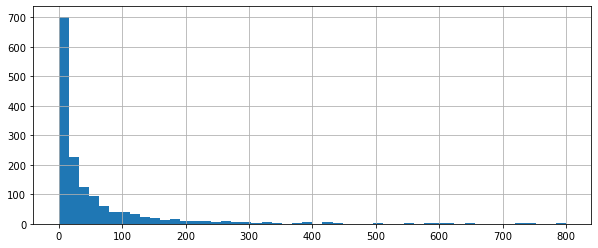

In [81]:
# importmatplotlib to visualize the ratings
import matplotlib.pyplot as plt 

# plot the number of ratings
plt.figure(figsize =(10, 4)) 
# limited to range 800 to get a better look
ratings['count_ratings'].hist(bins = 50, range=[0, 800]) 

<AxesSubplot:>

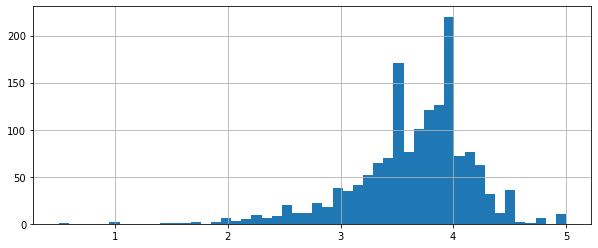

In [82]:
# check the distribution of ratings
plt.figure(figsize =(10, 4)) 
  
ratings['rating'].hist(bins = 50) 

Not necessarily normally distributed but looks as expected. As ususal round scores are chosen more frequently as human beings like 4's better than 4,1's. 
Similar to the commonly used example of a height of 6ft for men in dating apps... a surprisingly large amount of men seems to magically grow to the 6ft mark.

In [143]:
# creating table with movie title, ratings and number of ratings
moviemat = all_df.pivot_table(index ='userId_x', 
              columns ='title', values ='rating') 
# sort ratings data by number of ratings  
ratings.sort_values('count_ratings', ascending = False).head(10) 

,rating,count_ratings
title,,
Pulp Fiction (1994),4.197068,55567
Fight Club (1999),4.272936,11772
Star Wars: Episode IV - A New Hope (1977),4.231076,6526
Léon: The Professional (a.k.a. The Professional) (Léon) (1994),4.018797,4655
2001: A Space Odyssey (1968),3.894495,4469
Eternal Sunshine of the Spotless Mind (2004),4.160305,4454
Inception (2010),4.066434,3718
"Big Lebowski, The (1998)",3.924528,3392
Donnie Darko (2001),3.981651,3161


### Testing it with a single movie


In [144]:
# analysing correlation with similar movies for Pulp Fiction
pulp_user_ratings = moviemat['Pulp Fiction (1994)'] 

print("Top 10 Users & ratings for Pulp Fiction")
print(pulp_user_ratings.head(10)) 

Top 10 Users & ratings for Pulp Fiction
userId_x
1     3.0
2     NaN
3     NaN
4     1.0
5     5.0
6     2.0
7     NaN
8     4.0
9     NaN
10    1.0
Name: Pulp Fiction (1994), dtype: float64


In [145]:
# finding correlations in ratings from pulp fiction to other movies (ratings)
similar_to_pulp = moviemat.corrwith(pulp_user_ratings) # corrwith() computes pairwise correlation between movies (rows)

# correlation of Pulp Fiction with other movies (ratings) 
corr_pulp = pd.DataFrame(similar_to_pulp, columns =['Correlation']) 
corr_pulp.dropna(inplace = True) 
  
corr_pulp.head() 

C:\Users\lenaw\anaconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\lenaw\anaconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
title,
(500) Days of Summer (2009),-0.044034
...And Justice for All (1979),-0.188982
10 Cloverfield Lane (2016),-0.201347
10 Things I Hate About You (1999),-0.126206
101 Dalmatians (1996),0.289800


In [146]:
# Number of ratings is being taken into account
# movies that correlated with Pulp Fiction and showed correlating high rating with it
corr_pulp = corr_pulp.join(ratings['count_ratings']) 
corr_pulp[corr_pulp['count_ratings']>100].sort_values('Correlation', ascending = False).head(10) 

,Correlation,count_ratings
title,,
Pulp Fiction (1994),1.000000,55567
"Wolf of Wall Street, The (2013)",0.579915,270
Old Boy (2003),0.564115,312
Fight Club (1999),0.543465,11772
In the Mood For Love (Fa yeung nin wa) (2000),0.514500,252
Kill Bill: Vol. 1 (2003),0.504147,262
Interstellar (2014),0.503411,730
"Blair Witch Project, The (1999)",0.468343,128
Requiem for a Dream (2000),0.463093,288


## Implementation on  Interface
To not just give recommendations based on correlating ratings, but also let the user actively search for other movies that one might like.
Here the option to type in a movie and get recommendation based on ratings

In [89]:
# again sort ratings
ratings.sort_values('count_ratings', ascending = False).head(10) 

# introduce what's happening
search_c = input('\n Check out what movies other users liked that watched: ')
# search specific movie 
s_rating = moviemat[search_c]
# find pairwise correlations for that movie
s_similar_rating = moviemat.corrwith(s_rating)
# create new DataFrame with correlating movies
s_corr_movie = pd.DataFrame(s_similar_rating, columns =['Correlation'])
s_corr_movie.dropna(inplace = True)
# add the amount of ratings
s_corr_movie = s_corr_movie.join(ratings['count_ratings'])

# give a suggestion/recommendation depending on movie they chose
s_corr_movie[s_corr_movie['count_ratings']>150].sort_values('Correlation', ascending = False).head(10)



 Check out what movies other users liked that watched:  Fight Club (1999)


C:\Users\lenaw\anaconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\lenaw\anaconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,count_ratings
title,,
Fight Club (1999),1.000000,11772
The Lego Movie (2014),0.743619,217
"Wolf of Wall Street, The (2013)",0.718489,270
Django Unchained (2012),0.635760,852
Life Is Beautiful (La Vita è bella) (1997),0.629640,704
Interstellar (2014),0.621685,730
The Revenant (2015),0.613049,217
Old Boy (2003),0.606980,312
Pulp Fiction (1994),0.543465,55567


# Random Movie

## Implementation on the Interface
When the user choses the "chance mode" on the interface. All movies are "recommended" by chance and no ratings/preferences are taken into account. 
However one can still select random picks from specific genres and the different categories on the interface could change into the Genres with each a random choice of recommendations.

In [118]:
# here 10 completely random movies
random_movie = single_df.sample(10)
random_movie

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId,new_category
204372,45730,Lady in the Water (2006),"Drama, Fantasy, Mystery",7,0.5,1161738279,477,bad,1242580531,452637,9697.0,Mystery
201037,30812,"Aviator, The (2004)",Drama,7,3.5,1113353083,474,biopic,1138038949,338751,2567.0,Drama
192018,7218,"Ox-Bow Incident, The (1943)","Drama, Western",309,4.5,1086564148,474,In Netflix queue,1137179905,36244,980.0,Western
108383,973,Meet John Doe (1941),"Comedy, Drama",309,4.0,1086564073,474,journalism,1138306956,33891,32574.0,Comedy
201481,32587,Sin City (2005),"Action, Crime, Film-Noir, Mystery, Thriller",7,3.5,1128486479,336,cult,1139046748,401792,187.0,Thriller
181661,5349,Spider-Man (2002),"Action, Adventure, Sci-Fi, Thriller",7,3.5,1106636606,474,superhero,1137206068,145487,557.0,Adventure
199219,8961,"Incredibles, The (2004)","Action, Adventure, Animation, Children, Comedy",7,4.0,1106636064,474,Disney,1138040115,317705,9806.0,Animation
171432,4164,"Caveman's Valentine, The (2001)",Drama,474,4.0,1002757130,474,homeless,1138032589,182000,25208.0,Drama
182076,5445,Minority Report (2002),"Action, Crime, Mystery, Sci-Fi, Thriller",7,4.0,1106636707,474,future,1137206007,181689,180.0,Action
211053,60074,Hancock (2008),"Action, Adventure, Comedy, Crime, Fantasy",18,2.5,1455749302,62,bad script,1525554116,448157,8960.0,Action


In [115]:
# random movie from a specific genre like Comedy
random_movie_genre = single_df[single_df['new_category']== 'Comedy'].sample(10)

In [112]:
random_movie_genre.head(5)

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId,new_category
1341,11,"American President, The (1995)","Comedy, Drama, Romance",6,4.0,845553489,474,politics,1137374904,112346,9087.0,Comedy
183285,5685,Real Women Have Curves (2002),"Comedy, Drama",414,4.0,1072057972,474,Girl Power,1137206048,296166,30309.0,Comedy
148051,2791,Airplane! (1980),Comedy,4,5.0,964539628,474,aviation,1138031941,80339,813.0,Comedy
128294,1537,Shall We Dance? (Shall We Dansu?) (1996),"Comedy, Drama, Romance",33,4.0,939646982,474,ballroom dance,1137368308,117615,11239.0,Comedy
80469,317,"Santa Clause, The (1994)","Comedy, Drama, Fantasy",6,4.0,845553457,474,Christmas,1137374047,111070,11395.0,Comedy


In [117]:
# chosing random movies by genre
random_movie_search = input('What genre would you like to get random suggestions for?')
random_movie_sug = single_df[single_df['new_category']== random_movie_search].sample(10)
random_movie_sug

What genre would you like to get random suggestions for? Drama


,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,imdbId,tmdbId,new_category
187520,6452,"Long, Hot Summer, The (1958)",Drama,309,4.0,1086565163,474,In Netflix queue,1137201737,51878,40085.0,Drama
19068,261,Little Women (1994),Drama,5,4.0,847435238,474,Louisa May Alcott,1137181688,110367,9587.0,Drama
188545,6753,Secondhand Lions (2003),"Children, Comedy, Drama",68,3.0,1269123223,474,Animal movie,1138307295,327137,13156.0,Drama
201222,30850,"Merchant of Venice, The (2004)",Drama,334,3.5,1260653585,474,Shakespeare,1137181555,379889,11162.0,Drama
186272,6288,Better Luck Tomorrow (2002),"Crime, Drama",95,4.0,1071803767,474,gangs,1138307044,280477,14290.0,Drama
186268,6286,"Man Without a Past, The (Mies vailla menneisyy...","Comedy, Crime, Drama",346,3.5,1125857676,474,amnesia,1138039259,311519,7294.0,Drama
134674,1902,Dream for an Insomniac (1996),"Drama, Romance",474,4.0,1015352994,474,generation X,1138031706,116141,32284.0,Drama
164720,3462,Modern Times (1936),"Comedy, Drama, Romance",18,4.0,1476393345,474,factory,1137205526,27977,3082.0,Drama
146324,2745,"Mission, The (1986)",Drama,160,3.0,971116289,474,Missionary,1137202541,91530,11416.0,Drama
189762,7087,"Passage to India, A (1984)","Adventure, Drama",74,4.0,1207501191,474,E.M. Forster,1138039751,87892,15927.0,Drama


# Search Options on Interface:

In [129]:
# check data
single_df.head()
search_df = single_df[['title','genres', 'rating', 'tag']].copy()
search_df.sort_values('rating', ascending=False)


,title,genres,rating,tag
187486,Whale Rider (2002),Drama,5.0,Girl Power
121964,"Terminator, The (1984)","Action, Sci-Fi, Thriller",5.0,Action
197060,Oklahoma! (1955),"Musical, Romance, Western",5.0,Rogers and Hammerstein
197060,Oklahoma! (1955),"Musical, Romance, Western",5.0,Rogers and Hammerstein
118998,Star Wars: Episode VI - Return of the Jedi (1983),"Action, Adventure, Sci-Fi",5.0,darth vader
...,...,...,...,...
197569,Super Size Me (2004),"Comedy, Documentary, Drama",0.5,food
197569,Super Size Me (2004),"Comedy, Documentary, Drama",0.5,food
108556,Mary Poppins (1964),"Children, Comedy, Fantasy, Musical",0.5,Disney
98960,Wallace & Gromit: The Best of Aardman Animatio...,"Adventure, Animation, Comedy",0.5,Aardman


## Search for genre

In [137]:
### searching for a specific genre
search_1 = input('\nWhat genre are you looking for?')

# sort movies with that genre by rating
search_genre_movies = search_df[search_df['genres'] == search_1].sort_values("rating", ascending=False)
search_genre_movies = search_genre_movies.reset_index(drop=True)

# print out movies with high rating
print('\nOther liked movies with the genre: '.format(search_1))
search_genre_movies.sort_values('rating', ascending=False).head(10)


What genre are you looking for? Drama



Other liked movies with the genre: 


,title,genres,rating,tag
0,Two Family House (2000),Drama,5.0,In Netflix queue
33,Searching for Bobby Fischer (1993),Drama,5.0,chess
25,Midnight Express (1978),Drama,5.0,In Netflix queue
26,Inherit the Wind (1960),Drama,5.0,court
27,Secrets & Lies (1996),Drama,5.0,In Netflix queue
28,"Preacher's Wife, The (1996)",Drama,5.0,religion
29,Guess Who's Coming to Dinner (1967),Drama,5.0,Hepburn and Tracy
30,Mr. Smith Goes to Washington (1939),Drama,5.0,Politics
31,Warrior (2011),Drama,5.0,Boxing story
32,In the Name of the Father (1993),Drama,5.0,Ireland


## Search for tag

In [138]:
### searching for a specific tag
search_2 = input('\nWhat tag are you looking for?')

# sort movies with that tag by rating
search_tag_movies = search_df[search_df['tag'] == search_2].sort_values("rating", ascending=False)
search_tag_movies = search_tag_movies.reset_index(drop=True)

# print out movies with searched tag by rating
print('\nOther liked movies with the tag: '.format(search_2))
search_tag_movies.sort_values('rating', ascending=False).head(10)


What tag are you looking for? anime



Other liked movies with the tag: 


,title,genres,rating,tag
0,Tekkonkinkreet (Tekkon kinkurîto) (2006),"Action, Adventure, Animation, Crime, Fantasy",5.0,anime
5,Spirited Away (Sen to Chihiro no kamikakushi) ...,"Adventure, Animation, Fantasy",5.0,anime
7,Tekkonkinkreet (Tekkon kinkurîto) (2006),"Action, Adventure, Animation, Crime, Fantasy",5.0,anime
6,Tekkonkinkreet (Tekkon kinkurîto) (2006),"Action, Adventure, Animation, Crime, Fantasy",5.0,anime
1,Tekkonkinkreet (Tekkon kinkurîto) (2006),"Action, Adventure, Animation, Crime, Fantasy",5.0,anime
4,Spirited Away (Sen to Chihiro no kamikakushi) ...,"Adventure, Animation, Fantasy",5.0,anime
3,Spirited Away (Sen to Chihiro no kamikakushi) ...,"Adventure, Animation, Fantasy",5.0,anime
2,Tekkonkinkreet (Tekkon kinkurîto) (2006),"Action, Adventure, Animation, Crime, Fantasy",5.0,anime
8,Howl's Moving Castle (Hauru no ugoku shiro) (2...,"Adventure, Animation, Fantasy, Romance",4.5,anime
10,Howl's Moving Castle (Hauru no ugoku shiro) (2...,"Adventure, Animation, Fantasy, Romance",4.5,anime


## Search for a specific Movie

In [139]:
## searching for specific movie
search_3 = input('\nWhat movie are you looking for?')
search_spec_movie= search_df[search_df['title'] == search_3]
search_spec_movie.head(1)


What movie are you looking for? Fight Club (1999)


,title,genres,rating,tag
148882,Fight Club (1999),"Action, Crime, Drama, Thriller",5.0,dark comedy
